In [145]:
import pandas as pd
import statsmodels as sm
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import datetime,date
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.seasonal
from sklearn.preprocessing import MinMaxScaler

In [146]:
donnee =pd.read_table("train.csv",sep = ',',header = 0)

In [147]:
donnee.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'electricity_consumption'],
      dtype='object')

In [148]:
donnee=donnee[['temperature','electricity_consumption']]

In [149]:
donnee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
temperature                26496 non-null float64
electricity_consumption    26496 non-null float64
dtypes: float64(2)
memory usage: 414.1 KB


In [150]:
dataa=donnee[:552]

In [151]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 2 columns):
temperature                552 non-null float64
electricity_consumption    552 non-null float64
dtypes: float64(2)
memory usage: 8.7 KB


In [152]:
timesseries=pd.DataFrame(data= dataa.values, columns= ['temperature','electricity_consumption'] , index=pd.DatetimeIndex(start='2013-07-01 00:00:00' , periods=552 , freq='h'))
training=timesseries[:505]
test=timesseries['electricity_consumption'][505:]

In [153]:
timesseries.head()

,temperature,electricity_consumption
2013-07-01 00:00:00,-11.4,216.0
2013-07-01 01:00:00,-12.1,210.0
2013-07-01 02:00:00,-12.9,225.0
2013-07-01 03:00:00,-11.4,216.0
2013-07-01 04:00:00,-11.4,222.0


In [154]:
 #Test de stationarite
    
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Result of Dickey-Fuller Test:")
    df_test=adfuller(timeseries,autolag="AIC")
    df_output=pd.Series(df_test[0:4],index= ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    
    for k,val in df_test[4].items():
        df_output['valeur critique (%s)'%k]=val
    print(df_output)

In [155]:
import functools
training.apply(functools.partial(stationarity_test))

Result of Dickey-Fuller Test:
Test Statistic                  -3.949850
p-value                          0.001697
#Lags Used                      18.000000
Number of Observations Used    486.000000
valeur critique (1%)            -3.443877
valeur critique (5%)            -2.867505
valeur critique (10%)           -2.569947
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                  -4.035693
p-value                          0.001235
#Lags Used                       0.000000
Number of Observations Used    504.000000
valeur critique (1%)            -3.443392
valeur critique (5%)            -2.867292
valeur critique (10%)           -2.569833
dtype: float64


temperature                None
electricity_consumption    None
dtype: object

In [156]:
#Creation du model:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(training)


In [157]:
#chercher le meilleur model :

modselect = model.select_order(20)
modselect.summary()

,AIC,BIC,FPE,HQIC
0,10.23,10.25,2.785e+04,10.24
1,7.137,7.189*,1257.,7.157
2,7.127,7.214,1245.,7.161
3,7.121,7.242,1238.,7.168
4,7.056,7.212,1160.,7.117
5,7.010,7.200,1108.,7.084*
6,6.999*,7.223,1096.*,7.087
7,7.006,7.265,1104.,7.108
8,7.014,7.308,1112.,7.129
9,7.009,7.337,1107.,7.138


In [158]:
#recherche automatique le meilleur parametre:

results = model.fit(maxlags=20, ic='aic')
results.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Jan, 2020
Time:                     19:59:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.20012
Nobs:                     499.000    HQIC:                   7.06676
Log likelihood:          -3131.77    FPE:                    1075.62
AIC:                      6.98063    Det(Omega_mle):         1021.69
--------------------------------------------------------------------
Results for equation temperature
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -2.252567         0.370463           -6.080           0.000
L1.temperature                     0.613145         0.044842           13.673           0.000
L1

In [159]:
#Causalite par le test de Granger:
print('causalite de la temperature')
causalite1 = results.test_causality(['electricity_consumption'],['temperature'],kind='f')
causalite1.summary()



causalite de la temperature


Test statistic,Critical value,p-value,df
2.339,2.108,0.030,"(6, 972)"


In [160]:
'''print('causalite de la pression')
causalite2 = results.test_causality(['electricity_consumption'],['pressure'],kind='f')
causalite2.summary()
'''


"print('causalite de la pression')\ncausalite2 = results.test_causality(['electricity_consumption'],['pressure'],kind='f')\ncausalite2.summary()\n"

In [161]:
#print('causalite du vent')
#causalite3 = results.test_causality(['electricity_consumption'],['windspeed'],kind='f')
#causalite3.summary()

In [162]:
fcast= results.forecast(training.values, 48)

In [163]:
pd.DataFrame(fcast).head(5)

,0,1
0,-11.219265,384.278209
1,-11.220123,379.919024
2,-10.950107,366.934552
3,-10.841677,356.916954
4,-10.304967,345.776883


In [175]:
vallues=pd.DataFrame(fcast)[1]
vallues.head(10)
predict=pd.Series(vallues.values,index=pd.date_range('2013-07-22 00:00:00',periods=48,freq='h'))


In [179]:
predict=predict-15

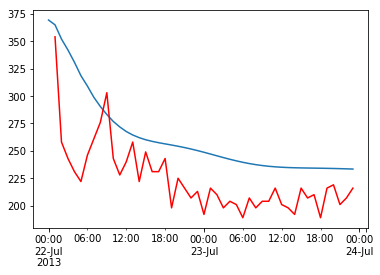

In [180]:
predict.plot()
test.plot(color='r')

plt.show()